In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import numpy as np

In [266]:

df = pd.read_csv('creditcard.csv')


The columns are features: due to privacity we don't know the columns name but we have time and amount: Time is the difference between the each transaction and the first transaction dataset and Amount is the transaction amount

# EDA

## Ver a distribuição das classes
Vamos ver como as classes estão distribuídas, isso pode nos ajudar a entender um pouco melhor os dados, como há no geral poucos dados fraudulentos é esperado que hajam bem mais registros de dados não fraudulentos do que de fraudulentos

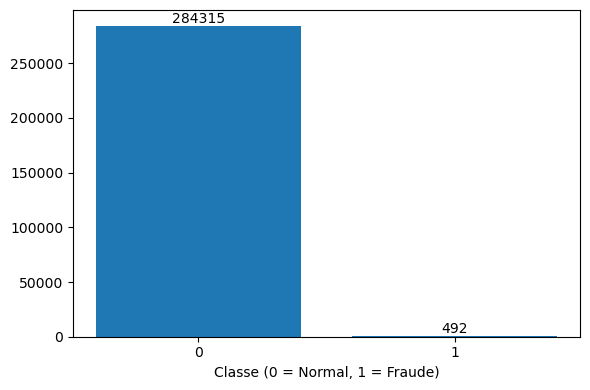

Percentual de dados fraudulentos: 0.173%
Percentual de dados não fraudulentos: 99.827%


In [267]:
class_count = df['Class'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(class_count.index.astype(str), class_count.values)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x()+bar.get_width()/2,
        height, 
        str(height),
        ha='center', 
        va='bottom'
    )
plt.xlabel('Classe (0 = Normal, 1 = Fraude)')
plt.tight_layout()
plt.show()
print(f"Percentual de dados fraudulentos: {round(100*class_count[1]/df.shape[0], 3)}%")
print(f"Percentual de dados não fraudulentos: {round(100*class_count[0]/df.shape[0], 3)}%")


## Estatística básica das variáveis
A ideia é olharmos para os números para entendermos melhor os dados

### Como as quantidades se relacionam com os dados fraudados

Podemos ver que a média dos dados fraudados ela é maior que a média dos dados normais mas a mediana não é, oque quer dizer que a maioria das transações fraudulentas, tem valores inferiores a media. E outra parte (75%) tem valores superiores, isso pode nos ajudar no futuro

In [268]:
fraude = df.where(df['Class'] == 1).describe()['Amount']
normal = df.where(df['Class'] == 0).describe()['Amount']
pd.DataFrame({'Normal': normal, 'Fraude': fraude})

,Normal,Fraude
count,284315.000000,492.000000
mean,88.291022,122.211321
std,250.105092,256.683288
min,0.000000,0.000000
25%,5.650000,1.000000
50%,22.000000,9.250000
75%,77.050000,105.890000
max,25691.160000,2125.870000


### Correlação entre as variáveis e os dados fraudados

Interessante notar que amount não está entre as principais variáveis que se relacionam com a classe. As principais são: V17, V14, V12 ,V10, V16, V3 e V7

In [ ]:
qtd_features = 3
correlations = df.corr(numeric_only=True)
class_correlations = correlations['Class'].drop('Class')
sorted_class_correlations = class_correlations.sort_values(key=abs, ascending=False)
important_features = ['Class']
important_features = important_features + sorted_class_correlations.index.tolist()[:qtd_features]
print(important_features)

['Class', 'V17', 'V14', 'V12']


## Avaliando o modelo

In [270]:
# Eu preciso dos dados sem classe
df = df[important_features]
X = df.drop(columns=['Class'])
y = df['Class']

# Eu preciso dos dados normais
X_normal_sample = df[df['Class'] == 0].drop(columns=['Class']).sample(n=2000, random_state=42)

## Agora eu preciso fazer o modelo entender quais são os dados normais, aplicando a padrozinação

standard_scaler = StandardScaler()
X_normal_sampled_scaled = standard_scaler.fit_transform(X_normal_sample) # guarda os valores de mi e sigma e depois aplica a transformação
X_scaled = standard_scaler.transform(X) # aplica a transformação com os valores já obtidos anteriormente


In [271]:
# Econtrar a melhor banda
params = {'bandwidth': np.linspace(0.1, 1, 20)}
grid = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=5)
grid.fit(X_normal_sampled_scaled)
print("Melhor bandwidth:", grid.best_params_['bandwidth'])
best_bw = grid.best_params_['bandwidth']

Melhor bandwidth: 0.4789473684210527


In [272]:
# O valor encontrado da melhor banda foi 0.599
kde = KernelDensity(bandwidth=best_bw, kernel='gaussian', algorithm='auto')
kde.fit(X_normal_sampled_scaled)

##Calcular o score dos dados
log_density = kde.score_samples(X_scaled)
anomalie_score = -log_density


In [273]:

df_scores = pd.DataFrame(
    {
        'anomaly_score': anomalie_score,
        'true_class': y
    }
)
print('Fraude')
print(df_scores[df_scores['true_class'] == 1].describe(), end='\n\n')
print('Normal')
print(df_scores[df_scores['true_class'] == 0].describe())


Fraude
       anomaly_score  true_class
count     492.000000       492.0
mean      162.766740         1.0
std       250.679879         0.0
min         2.780611         1.0
25%        26.711496         1.0
50%        68.714390         1.0
75%       156.108730         1.0
max      1377.747682         1.0

Normal
       anomaly_score  true_class
count  284315.000000    284315.0
mean        3.818309         0.0
std         4.005647         0.0
min         2.346846         0.0
25%         2.822756         0.0
50%         3.311860         0.0
75%         4.210312         0.0
max       557.518645         0.0


In [274]:
precision, recall, thresholds = precision_recall_curve(df_scores['true_class'], df_scores['anomaly_score'])
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
f1_scores_indx = f1_scores.argmax()
threshold = thresholds[f1_scores_indx]
print("Melhor threshold (com maior F1 na curva PR):", threshold)

Melhor threshold (com maior F1 na curva PR): 34.90026190687405


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.60      0.71      0.65       492

    accuracy                           1.00    284807
   macro avg       0.80      0.85      0.82    284807
weighted avg       1.00      1.00      1.00    284807



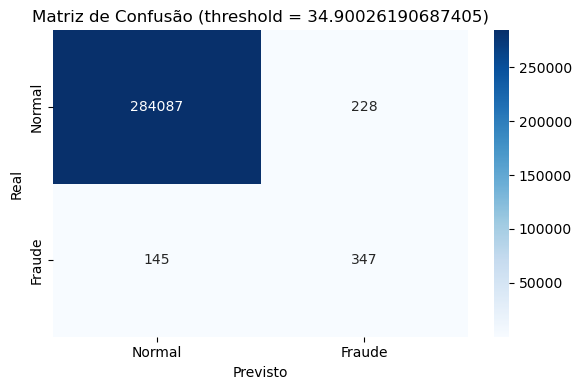

In [279]:
# threshold = 1133.7435422923106
y_pred = (df_scores['anomaly_score'] > threshold).astype(int)

# Avaliação
print(classification_report(df_scores['true_class'], y_pred))

# Matriz de confusão
cm = confusion_matrix(df_scores['true_class'], y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão (threshold = {threshold})')
plt.tight_layout()
plt.show()


In [278]:

auc_pr = average_precision_score(df_scores['true_class'], df_scores['anomaly_score'])
print(f"AUC-PR: {auc_pr:.4f}")

AUC-PR: 0.6230
